In [0]:
import pandas as pd
import numpy as np
import matplotlib as pyplot
%matplotlib inline 
import seaborn as sns


In [0]:
import mlflow.sklearn

In [0]:
df = pd.read_csv("/tmp/loan_data.csv")
df.count()

Out[8]: credit.policy        9578
purpose              9578
int.rate             9578
installment          9578
log.annual.inc       9578
dti                  9578
fico                 9578
days.with.cr.line    9578
revol.bal            9578
revol.util           9578
inq.last.6mths       9578
delinq.2yrs          9578
pub.rec              9578
not.fully.paid       9578
dtype: int64

Out[26]: <seaborn.axisgrid.PairGrid at 0x7f74d48324c0>

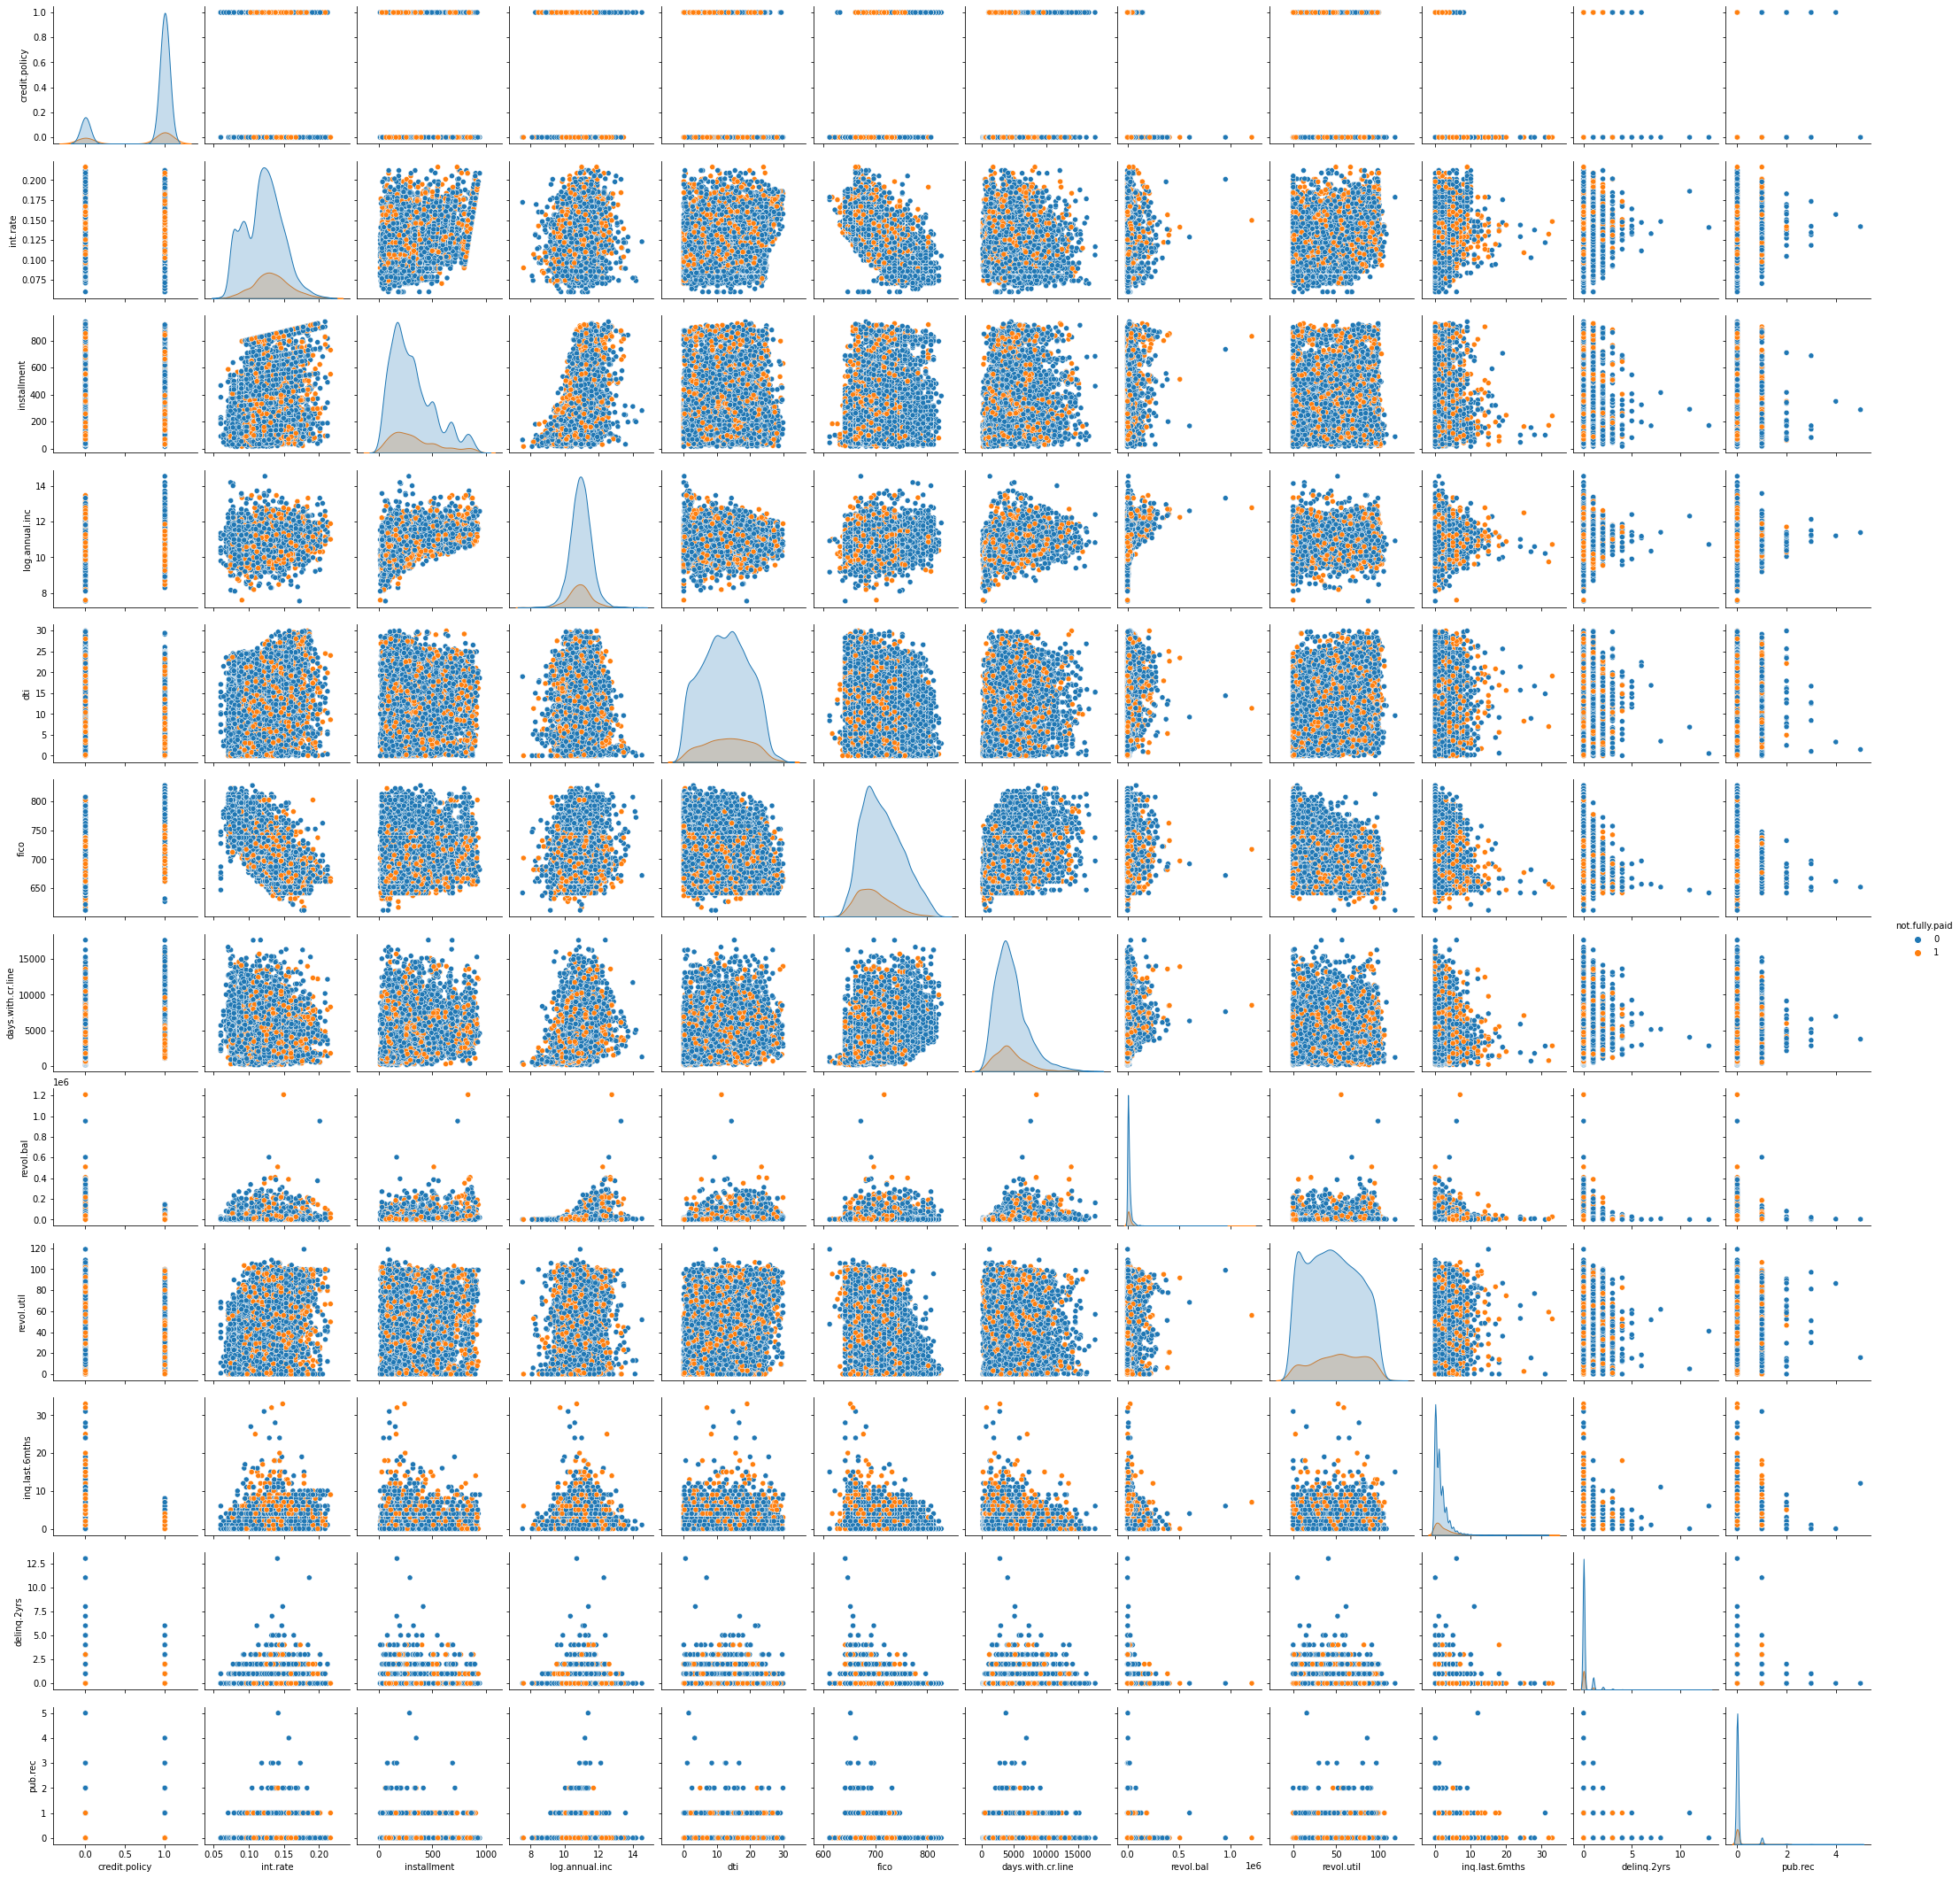

In [0]:
sns.pairplot(df , hue = 'not.fully.paid')

In [0]:
cat_feats = ['purpose']
final_data = pd.get_dummies(df , columns=cat_feats,drop_first=True)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X = final_data.drop('not.fully.paid',axis=1)
y = final_data['not.fully.paid']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(   X, y, test_size=0.4, random_state=101) 

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rfc = RandomForestClassifier()

In [0]:
rfc.fit(X_train,y_train)

Out[15]: RandomForestClassifier()

In [0]:
predictions = rfc.predict(X_test)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [0]:
import os
import numpy as np
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score

class RFRModel():
    """
    General class for Scikit-Learn RandomForestRegressor
    """
    # class wide variables common to all instances
    # that keep track of cumulative estimators and rmse
    # so we can plot the results to see how it fairs w.r.t
    # rmse
    rmse = []
    estimators = []

    def __init__(self, params={}):
        """
        Constructor for the RandomForestRegressor
        :param params: dictionary to RandomForestRegressor
        """
        # unpack dictionary as kwargs to the class constructor
        self._rf = RandomForestClassifier(**params)
        self._params = params

    @classmethod
    def new_instance(cls, params={}):
        return cls(params)

    @property
    def model(self):
        """
        Getter to return the model created
        :return: handle or instance of the RandomForestReqgressor
        """
        return self._rf

    @property
    def params(self):
      """
      Getter for model parameters 
      """
      return self._params
      
    def mlflow_run(self, X,y, r_name="Lab-1:RF Petrol Regression Experiment"):
        """
        This method trains, computes metrics, and logs all metrics, parameters,
        and artifacts for the current run using the MLflow APIs
        :param df: pandas dataFrame
        :param r_name: Name of the run as logged by MLflow
        :return: MLflow Tuple (ExperimentID, runID)
        """

        with mlflow.start_run(run_name=r_name) as run:

            # get current run and experiment id
            runID = run.info.run_uuid
            experimentID = run.info.experiment_id
            
            # extract all feature independent attributes
            #X = df.iloc[:, 0:4].values
            # extract all the values of last columns, dependent variables,
            # which is what we want to predict as our values, the petrol consumption
            #y = df.iloc[:, 4].values

            # create train and test data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

            # Feature Scaling, though for RF is not necessary.
            # z = (X - u)/ s, where u is the mean, s the standard deviation
            # get the handle to the transformer
            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_test = sc.transform(X_test)

            # train and predict
            self._rf.fit(X_train, y_train)
            y_pred = self._rf.predict(X_test)

            # Log model and params using the MLflow APIs
            mlflow.sklearn.log_model(self.model, "random-forest-reg-model")
            mlflow.log_params(self.params)

            # compute  regression evaluation metrics 
            mae = metrics.mean_absolute_error(y_test, y_pred)
            mse = metrics.mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = metrics.r2_score(y_test, y_pred)

            # Log metrics
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)

            # update global class instance variable with values
            self.rmse.append(rmse)
            self.estimators.append(self.params["n_estimators"])

            # plot graphs and save as artifacts

          
            # print some data
            print("-" * 100)
            print("Inside MLflow Run with run_id {} and experiment_id {}".format(runID, experimentID))
            print("Estimator trees        :", self.params["n_estimators"])
            print('Mean Absolute Error    :', mae)
            print('Mean Squared Error     :', mse)
            print('Root Mean Squared Error:', rmse)
            print('R2                     :', r2)
            
            class_report = classification_report(y_test,y_pred, output_dict=True)
            recall_0 = class_report['0']['recall']
            f1_score_0 = class_report['0']['f1-score']
            recall_1 = class_report['1']['recall']
            f1_score_1 = class_report['1']['f1-score']
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            conf_matrix = confusion_matrix(y_test,y_pred)
            true_positive = conf_matrix[0][0]
            true_negative = conf_matrix[1][1]
            false_positive = conf_matrix[0][1]
            false_negative = conf_matrix[1][0]
            
            mlflow.log_metric("accuracy_score", acc)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("f1_score_0", f1_score_0)
            mlflow.log_metric("f1_score_1", f1_score_1)
            
            print("accuracy_score", acc)
            print("precision", precision)
            print("true_positive", true_positive)
            print("true_negative", true_negative)
            print("false_positive", false_positive)
            print("false_negative", false_negative)
            print("recall_0", recall_0)
            print("f1_score_0", f1_score_0)
            print("recall_1", recall_1)
            print("f1_score_1", f1_score_1)

            return (experimentID, runID)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
confusion_matrix(y_test,predictions)


Out[19]: array([[3216,   21],
       [ 572,   23]])

In [0]:
token = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get()
dbutils.fs.put("file:///root/.databrickscfg","[DEFAULT]\nhost=https://community.cloud.databricks.com\ntoken = "+token,overwrite=True)

Wrote 98 bytes.
Out[20]: True

In [0]:
params = {"n_estimators": 200, "max_depth": 20}
rfr = RFRModel.new_instance(params)
(experimentID, runID) = rfr.mlflow_run(X,y)

----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id 83269b7d0b2047c48ca208b9770e36bb and experiment_id 1412170873678747
Estimator trees        : 200
Mean Absolute Error    : 0.1581419624217119
Mean Squared Error     : 0.1581419624217119
Root Mean Squared Error: 0.39767067080904006
R2                     : -0.19426061734363254
accuracy_score 0.8418580375782881
precision 0.4375
true_positive 1606
true_negative 7
false_positive 9
false_negative 294
recall_0 0.9944272445820433
f1_score_0 0.9137980085348506
recall_1 0.023255813953488372
f1_score_1 0.04416403785488959


In [0]:
max_depth = 0
for n in range (20, 250, 50):
  max_depth = max_depth + 3
  params = {"n_estimators": n, "max_depth": max_depth}
  rfr = RFRModel.new_instance(params)
  (experimentID, runID) = rfr.mlflow_run(X,y)
  print("MLflow Run completed with run_id {} and experiment_id {}".format(runID, experimentID))
  print("-" * 100)

----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id 8e758e8a248f443ca8c1f9d3a84945fe and experiment_id 1412170873678747
Estimator trees        : 20
Mean Absolute Error    : 0.15709812108559498
Mean Squared Error     : 0.15709812108559498
Root Mean Squared Error: 0.3963560534236799
R2                     : -0.18637770897832806
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

In [0]:
 class_report = classification_report(y_test,y_pred, output_dict=True)
 recall_0 = class_report['0']['recall']
 f1_score_0 = class_report['0']['f1-score']
 recall_1 = class_report['1']['recall']
 f1_score_1 = class_report['1']['f1-score']
 acc = accuracy_score(y_test, y_pred)
 precision = precision_score(y_test, y_pred)
 conf_matrix = confusion_matrix(y_test,y_pred)
 true_positive = conf_matrix[0][0]
 true_negative = conf_matrix[1][1]
 false_positive = conf_matrix[0][1]
 false_negative = conf_matrix[1][0]

In [0]:
print("recall_0",recall_0)
#roc = metrics.roc_auc_score(y_test, y_pred)

recall_0 0.9932035835650294


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-1412170873678762> in <module>
      1 print("recall_0",recall_0)
----> 2 roc = metrics.roc_auc_score(y_test, y_pred)

NameError: name 'metrics' is not defined

In [0]:
print("accuracy_score", acc)
print("precision", precision)
print("true_positive", true_positive)
print("true_negative", true_negative)
print("false_positive", false_positive)
print("false_negative", false_negative)
print("recall_0", recall_0)
print("f1_score_0", f1_score_0)
print("recall_1", recall_1)
print("f1_score_1", f1_score_1)
#print("roc", roc)

accuracy_score 0.843945720250522
precision 0.4634146341463415
true_positive 3215
true_negative 19
false_positive 22
false_negative 576
recall_0 0.9932035835650294
f1_score_0 0.914911781445646
recall_1 0.031932773109243695
f1_score_1 0.05974842767295597


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-1412170873678763> in <module>
      9 print("recall_1", recall_1)
     10 print("f1_score_1", f1_score_1)
---> 11 print("roc", roc)

NameError: name 'roc' is not defined

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

est = RandomForestClassifier(n_jobs=-1)
rf_p_dist={    'max_depth':[3,5,10,None],
               'n_estimators':[10,100,200,300,400,500],
               'max_features':randint(1,3),
               'criterion':['gini','entropy'],
               'bootstrap':[True,False],
               'min_samples_leaf':randint(1,4),
              }
def hypertuning_rscv(est, p_distr, nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,
                                  n_jobs=-1, n_iter=nbr_iter, cv=9)
    #CV = Cross-Validation ( here using Stratified KFold CV)
    rdmsearch.fit(X,y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

rf_parameters, rf_ht_score = hypertuning_rscv(est, rf_p_dist, 40, X, y)
print (rf_parameters , rf_ht_score)

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 2, 'n_estimators': 10} 0.8399458152423311


In [0]:
#params = {"n_estimators": 200, "max_depth": 20}
params = { 'criterion': 'entropy', 'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 2, 'n_estimators': 10 }
rfr = RFRModel.new_instance(params)
(experimentID, runID) = rfr.mlflow_run(X,y)

----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id 4ebe41fa70104bb5a679b778f3df493d and experiment_id 1412170873678747
Estimator trees        : 10
Mean Absolute Error    : 0.15709812108559498
Mean Squared Error     : 0.15709812108559498
Root Mean Squared Error: 0.3963560534236799
R2                     : -0.18637770897832806
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

In [0]:
with mlflow.start_run(run_name='testing') as run:
  
  mlflow.sklearn.log_model(RandomForestClassifier(),
    artifact_path="dbfs:/databricks/mlflow-tracking/1412170873678747/8b1798f3a47c49738e102bc41c524ca5/artifacts/random-forest-reg-model/MLmodel",
    registered_model_name="test_model"
  )

---------------------------------------------------------------------------
RestException                             Traceback (most recent call last)
<command-912889804234376> in <module>
      1 with mlflow.start_run(run_name='testing') as run:
      2 
----> 3   mlflow.sklearn.log_model(RandomForestClassifier(),
      4     artifact_path="dbfs:/databricks/mlflow-tracking/1412170873678747/8b1798f3a47c49738e102bc41c524ca5/artifacts/random-forest-reg-model/MLmodel",
      5     registered_model_name="test_model"

/databricks/python/lib/python3.8/site-packages/mlflow/sklearn/__init__.py in log_model(sk_model, artifact_path, conda_env, serialization_format, registered_model_name, signature, input_example, await_registration_for, pip_requirements, extra_pip_requirements)
    367         mlflow.sklearn.log_model(sk_model, "sk_models")
    368     """
--> 369     return Model.log(
    370         artifact_path=artifact_path,
    371         flavor=mlflow.sklearn,

/databricks/python/lib/py